Início rápido
==========

Esta seção aborda a API para tarefas comuns em aprendizado de máquina.  
Consulte os links em cada seção para se aprofundar.

Trabalhando com dados
-----------------

O PyTorch tem dois [primitivos para trabalhar com dados](https://pytorch.org/docs/stable/data.html):
`torch.utils.data.DataLoader` e `torch.utils.data.Dataset`.  
`Dataset` armazena as amostras e seus rótulos correspondentes e `DataLoader` envolve um iterável em torno do `Dataset`.


In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import random

print(f"Pytorch Version: {torch.__version__}") 
print(f"Device: {torch.cuda.get_device_name()}")

Pytorch Version: 2.9.0+cu126
Device: NVIDIA GeForce GTX 1060


O PyTorch oferece bibliotecas específicas de domínio, como
[TorchText](https://pytorch.org/text/stable/index.html),
[TorchVision](https://pytorch.org/vision/stable/index.html), and
[TorchAudio](https://pytorch.org/audio/stable/index.html), 
todas elas incluindo conjuntos de dados. 
Neste tutorial, usaremos um conjunto de dados TorchVision.

O módulo `torchvision.datasets` contém `Dataset` objetos para diversos dados de visão do mundo real, como CIFAR e COCO
([lista completa aqui](https://pytorch.org/vision/stable/datasets.html)). 
Neste tutorial, usamos o conjunto de dados FashionMNIST. 
Cada `Dataset` TorchVision, inclui dois argumentos: `transform` e `target_transform` 
para modificar as amostras e os rótulos, respectivamente.


In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100.0%
100.0%
100.0%
100.0%


Passamos o `Dataset` como argumento para `DataLoader`. Isso envolve um iterável sobre nosso conjunto de dados e suporta processamento em lote, amostragem, embaralhamento e carregamento de dados multiprocesso automáticos. Aqui, definimos um tamanho de lote de 64, ou seja, cada elemento no iterável do carregador de dados retornará um lote de 64 recursos e rótulos.


In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


Leia mais sobre como [carregar dados no PyTorch](https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html).


------------------------------------------------------------------------


Criando Modelos
===============

Para definir uma rede neural no PyTorch, criamos uma classe que herda de 
[nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).
Definimos as camadas da rede na função `__init__` e
especificamos como os dados passarão pela rede na função `forward`.
Para acelerar as operações na rede neural, movemos a rede para um
[acelerador](https://pytorch.org/docs/stable/torch.html#accelerators)
como CUDA, MPS, MTIA ou XPU. Se o acelerador atual estiver disponível, 
o utilizaremos. Caso contrário, utilizaremos a CPU.

In [4]:
# Pytourch Acceleration only available in version 2.9 and above
#device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
device = "cuda" if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Leia mais sobre como [construir redes neurais no PyTorch ](https://docs.pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html).


------------------------------------------------------------------------


Otimizando os Parâmetros do Modelo
===============================

Para treinar um modelo, precisamos de uma 
[função de perda](https://pytorch.org/docs/stable/nn.html#loss-functions) e um
[otimizador](https://pytorch.org/docs/stable/optim.html).


In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

Em um único loop de treinamento, o modelo faz previsões no conjunto de dados de treinamento (alimentados em lotes) e retropropaga o erro de previsão para ajustar os parâmetros do modelo.

In [6]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

Também verificamos o desempenho do modelo em relação ao conjunto de dados de teste para garantir que ele esteja aprendendo.


In [7]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

O processo de treinamento é conduzido ao longo de várias iterações ( épocas ). Durante cada época, o modelo aprende parâmetros para fazer previsões melhores. Imprimimos a precisão e a perda do modelo em cada época; gostaríamos de ver a precisão aumentar e a perda diminuir a cada época.


In [8]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.289763  [   64/60000]
loss: 2.283062  [ 6464/60000]
loss: 2.268057  [12864/60000]
loss: 2.270392  [19264/60000]
loss: 2.254349  [25664/60000]
loss: 2.219571  [32064/60000]
loss: 2.228960  [38464/60000]
loss: 2.189496  [44864/60000]
loss: 2.192356  [51264/60000]
loss: 2.165545  [57664/60000]
Test Error: 
 Accuracy: 44.3%, Avg loss: 2.153029 

Epoch 2
-------------------------------
loss: 2.151808  [   64/60000]
loss: 2.143929  [ 6464/60000]
loss: 2.089350  [12864/60000]
loss: 2.114713  [19264/60000]
loss: 2.065974  [25664/60000]
loss: 1.999365  [32064/60000]
loss: 2.026712  [38464/60000]
loss: 1.941624  [44864/60000]
loss: 1.950356  [51264/60000]
loss: 1.884955  [57664/60000]
Test Error: 
 Accuracy: 57.9%, Avg loss: 1.874240 

Epoch 3
-------------------------------
loss: 1.895740  [   64/60000]
loss: 1.867602  [ 6464/60000]
loss: 1.752859  [12864/60000]
loss: 1.803537  [19264/60000]
loss: 1.696598  [25664/60000]
loss: 1.635902  [32064/600

Leia mais sobre [Treinamento do seu modelo](https://docs.pytorch.org/tutorials/beginner/basics/optimization_tutorial.html).


------------------------------------------------------------------------


Salvando Modelos
=============

Uma maneira comum de salvar um modelo é serializar o dicionário de estado interno (contendo os parâmetros do modelo).


In [9]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


Carregando modelos
==============

O processo de carregamento de um modelo inclui recriar a estrutura do modelo e carregar o dicionário de estado nele.


In [10]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

Este modelo agora pode ser usado para fazer previsões.


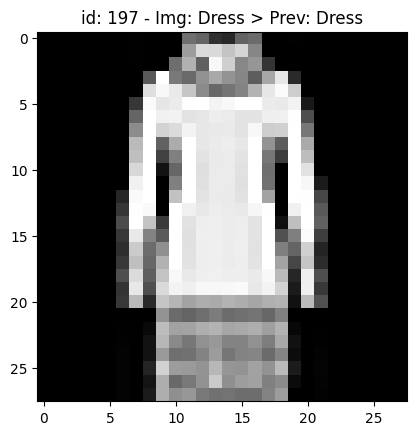

In [11]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()

with torch.no_grad():
    for i in random.sample(range(101, 200), 1):
        x, y = test_data[i][0], test_data[i][1]

        x = x.to(device)
        pred = model(x)
        predicted, actual = classes[pred[0].argmax(0)], classes[y]

        imagem_np = x.squeeze().cpu().numpy()
        plt.imshow(imagem_np, cmap="gray")
        plt.title(f'id: {i} - Img: {classes[y]} > Prev: {predicted}')
        plt.show()  

        #print(f'Predicted: "{predicted}", Actual: "{actual}"')

Leia mais sobre [como salvar e carregar seu modelo](https://docs.pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html).
